In [1]:
import os
import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import nilmtk
from nilmtk import DataSet, MeterGroup
from nilmtk.datastore import HDFDataStore

from MyDataSet import MyChunk
with torch.no_grad():
    torch.cuda.empty_cache() 

In [2]:
!ls

'Dataset and Model Test.ipynb'	 __pycache__
 dataset.py			' Pytorch input shapes.ipynb'
 FridgeSTATE.ipynb		 S2P.py
 lightning_logs			 SAED_dot.py
 metrics.py			 SS2P.py
 _modules_doesntwork.py		 test3.h5
 modules.py			 test4.h5
 MyDataSet.py			'Test->Dataset.ipynb'


In [3]:
sample_period = 6
d_name = 'UKDALE'
# device = 'kettle'
device = 'fridge'
path = '/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/data/{}/{}.h5'.format(d_name,d_name)
dates = ["2013-01-01","2013-10-01"]
building = 1
train_dataset = MyChunk(path=path, building=building, window_size=50,
                  device=device, dates=dates)# sample_period=sample_period)
train_loader = DataLoader(train_dataset, batch_size=1024, 
                          shuffle=False, num_workers=8)

In [4]:
train_dataset.mmax

6898.85009765625

In [12]:
for batch in train_loader:
    '''x -> mains sequence
       y -> target sequence
    '''
    mains, meter = batch
    print('mains shape ', mains.shape, 'meter shape ', meter.shape)
    break
    

mains shape  torch.Size([1024, 50]) meter shape  torch.Size([1024])


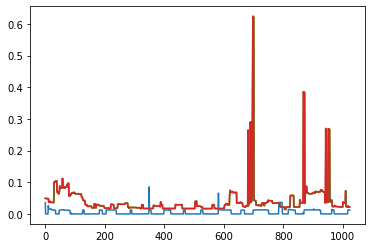

In [18]:
import matplotlib.pyplot as plt
plt.plot(meter[:1024])
plt.plot(mains[:1024, 10:11])
plt.plot(mains[:1024, 10:12])

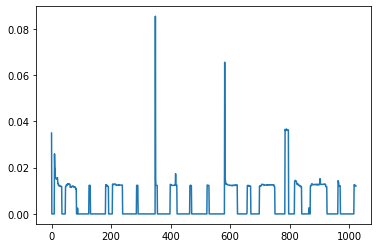

In [14]:
plt.plot(meter[:1024])

In [22]:
d_name = 'UKDALE'
# device = 'kettle'
device = 'fridge'
path = '/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/data/{}/{}.h5'.format(d_name,d_name)
dates = ["2013-10-01", "2013-10-15"]
building = 1
window_size = 50
test_dataset = MyChunk(path=path, building=building, window_size=window_size,
                  device=device, dates=dates, test=True, mmax=train_dataset.mmax)
test_loader = DataLoader(test_dataset, batch_size=1024, 
                          shuffle=False, num_workers=8)

In [23]:
from modules import WGRU
from S2P import S2P
from pytorch_lightning import Trainer

In [24]:
# trainer = Trainer(fast_dev_run=True)
trainer = Trainer(gpus=1,max_epochs=5)
# model = WGRU(dropout=0.5)
model = S2P(dropout=0.5)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | conv   | Sequential | 47.1 K
1 | dense  | _Dense     | 2.6 M 
2 | output | Linear     | 1.0 K 
--------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.437    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [26]:
# The filename of the resulting datastore
disag_filename = 'test4.h5' 

# window_size = 50
timeframe = test_dataset.timeframe
building = test_dataset.building
cols_name = test_dataset.chunk_name
mmax = train_dataset.mmax

meter_metadata = train_dataset.meter_metadata

model.set_disaggregation_meta(building, timeframe, 
                              cols_name, mmax, disag_filename, meter_metadata)
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/NewPaper/MyCode/S2P.py:119: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, y)
/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/NewPaper/MyCode/S2P.py:119: UserWarning: Using a target size (torch.Size([448])) that is different to the input size (torch.Size([448, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, y)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 5.751536809839308e-05}
--------------------------------------------------------------------------------


[{'val_loss': 5.751536809839308e-05}]

In [27]:
preds = model.final_preds
len(preds)

16832

In [28]:
for batch in test_loader:
    '''x -> mains sequence
       y -> target sequence
    '''
    x, ground_truth = batch
    print('x shape ', x.shape, 'y shape ', y.shape)
#     print(x, y)
    break
    

x shape  torch.Size([1024, 50]) y shape  torch.Size([1024])


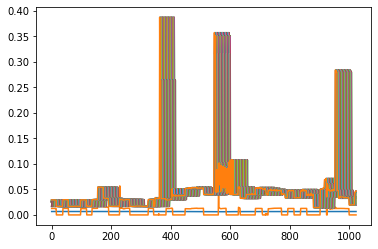

In [35]:
import matplotlib.pyplot as plt
plt.plot(preds[:1024])
plt.plot(ground_truth[:1024])
plt.plot(x[:1024])

<class 'nilmtk.elecmeter.ElecMeter'>


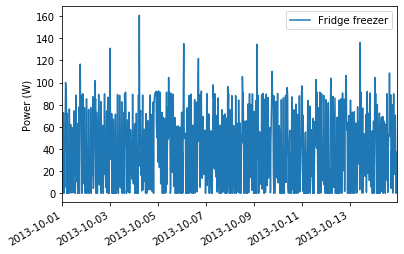

True threshold:  50
Pred threshold:  50


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [12]:
result = DataSet(disag_filename)
res_elec = result.buildings[building].elec
predicted = res_elec[device]
print(type(predicted))
ground_truth = test_dataset.meter_metadata

import matplotlib.pyplot as plt
# predicted.plot()
ground_truth.plot()
plt.show()

rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)

print("Recall: {}".format(rpaf[0]))
print("Precision: {}".format(rpaf[1]))
print("Accuracy: {}".format(rpaf[2]))
print("F1 Score: {}".format(rpaf[3]))

print("Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))

print("Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

In [ ]:
# l = model.final_preds
# l[0:100]

In [ ]:

# a = torch.randn(1024, 1, 50)  
# print(a.size())
# a = nn.ZeroPad2d((5,4,0,0))(a)
# a = nn.Conv1d(1, 30, kernel_size=10)(a)
# print(a.size())
# a = nn.ZeroPad2d((3,3,0,0))(a)
# a = nn.Conv1d(30, 30, kernel_size=8)(a)
# print(a.size())
# a = nn.ZeroPad2d((3,3,0,0))(a)
# a = nn.Conv1d(30, 40, kernel_size=6)(a)
# print(a.size())
# a = nn.ZeroPad2d((2,2,0,0))(a)
# a = nn.Conv1d(40, 50, kernel_size=5)(a)
# print(a.size())
# a = nn.ZeroPad2d((2,2,0,0))(a)
# a = nn.Conv1d(50, 50, kernel_size=5)(a)
# a = nn.Flatten()(a)
# print(a.size())

In [ ]:
# a = torch.randn(1024, 1, 50)  
# a[:,:,:-1].shape

In [ ]:
# a = torch.randn(1024, 1, 50)  
# print(a.size())
# a = nn.ZeroPad2d((2,1,0,0))(a)
# a = nn.Conv1d(1, 16, kernel_size=4)(a)
# print(a.size())

In [ ]:
# a.numpy()